This notebook contains the core codebase developed for the Master’s thesis titled "Large Language Models in Applied Qualitative Research: A Structured Pipeline for Automated Thematic Analysis and Model Evaluation."
It focuses on the evaluation component of the thesis, applying and benchmarking a structured LLM-based pipeline for inductive thematic analysis.

The goal of this code is to assess how reliably and accurately large language models (LLMs) can support or automate key steps of thematic analysis, particularly when working with transcribed audio feedback collected via the Voicy AG platform.

This notebook exemplifies the evaluation of the **Mistral** model, comparing its coding performance to human analysis. All other models in the study were tested using the same standardized procedure.



Author: Mélanie Bigler

May 2025

# 1. Preparing Environment and Data

In this step, we load both the LLM-generated data and the human-coded data into a unified format.  
Each dataset contains the following columns:

- `person_ID`
- `question_ID`
- `original_answer`
- `quote`
- `code`
- `code_description`
- `theme_name`
- `theme_description`

Additionally, for each quote, a unique `quote_ID` is generated.

Furthermore, all necessary libraries and the sentence embedding model are loaded.

In [ ]:
# Standard library
import json

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning metrics
from sklearn.metrics.pairwise import cosine_similarity

# NLP models and evaluation
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util

In [ ]:
# Initialize NLP evaluation tools
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)
model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")

In [ ]:
# Example of data_human
data_human.head(1)

,Person_ID,Aussage,Question_ID,quote,theme_name,code,Quote_ID,code_description,theme_description
0,1,2.0,1,"Das ganze Team war dort, wo wir zusammen unser...",Erfolgsfaktor Team (/Organisation),Gutes Klima,Q002,"Ein positives Klima, eine schöne Stimmung, ein...","Die Überkategorie ""Erfolgsfaktor Team (/Organi..."


In [ ]:
# Example of data_llm
data_llm.head(1)

,Person_ID,Question,Answer,quote,code,theme_name,code_description,theme_description,Quote_ID,Question_ID
0,1,Welche Momente in diesem Jahr haben bei dir ei...,Wenn ich über das letzte Jahr nachdenke und am...,Wenn ich über das letzte Jahr nachdenke und am...,Feeling Trusted by Others,Enhancing Leadership and Team Dynamics,Experiencing trust from colleagues or superior...,This theme focuses on the strengths and develo...,Q001,1.0


# 2. Statistical Comparison Between Human and LLM Outputs

In this step, we perform a statistical evaluation to compare the codings generated by a LLM with those created by human analysts.

The objective is to assess the alignment between automated and manual thematic analysis and to quantify how closely the LLM replicates human coding patterns.



In [ ]:
# Compare total number of quotes
total_quotes_llm = data_llm['quote'].nunique()
total_quotes_human = data_human['quote'].nunique()

print(f"Total Quotes (LLM): {total_quotes_llm}")
print(f"Total Quotes (Human): {total_quotes_human}")

Total Quotes (LLM): 354
Total Quotes (Human): 391


In [ ]:
# Compare number of quotes per Person_ID
quotes_per_person_llm = data_llm.groupby('Person_ID')['quote'].nunique()
quotes_per_person_human = data_human.groupby('Person_ID')['quote'].nunique()

# Merge into a single overview table
quote_counts = pd.concat(
    [quotes_per_person_human, quotes_per_person_llm],
    axis=1
).fillna(0).astype(int)

quote_counts.columns = ["Human_Quotes", "LLM_Quotes"]
quote_counts.reset_index(inplace=True)

print(quote_counts)

   Person_ID  Human_Quotes  LLM_Quotes
0          1            52          50
1          2            27          31
2          3            48          36
3          4            22          18
4          8            41          35
5         10            31          54
6         15            47          31
7         18            39          31
8         31            49          30
9         33            35          38


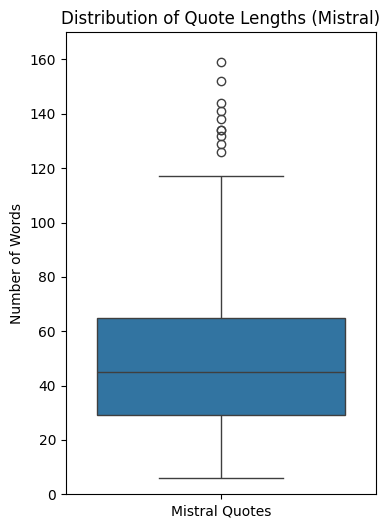

In [ ]:
# Calculate length (word count) for each quote
llm_lengths = data_llm["quote"].dropna().apply(lambda x: len(str(x).split()))
human_lengths = data_human["quote"].dropna().apply(lambda x: len(str(x).split()))

# Prepare DataFrame for plotting (Mistral example only)
length_df = pd.DataFrame({
    "Source": ["Mistral Quotes"] * len(llm_lengths),
    "Length (words)": llm_lengths
})

# Plot quote lengths using a boxplot
plt.figure(figsize=(4, 6))
sns.boxplot(data=length_df, x="Source", y="Length (words)")
plt.ylabel("Number of Words")
plt.xlabel("")
plt.ylim(0, 170)
plt.title("Distribution of Quote Lengths (Mistral)")
plt.show()

In [ ]:
# Compare number of unique codes
unique_codes_llm = data_llm['code'].nunique()
unique_codes_human = data_human['code'].dropna().nunique()

print(f"Unique Codes (LLM): {unique_codes_llm}")
print(f"Unique Codes (Human): {unique_codes_human}")

Unique Codes (LLM): 29
Unique Codes (Human): 54


In [ ]:
# Compare number of unique themes
unique_themes_llm = data_llm['theme_name'].nunique()
unique_themes_human = data_human['theme_name'].dropna().nunique()

print(f"Unique Themes (LLM): {unique_themes_llm}")
print(f"Unique Themes (Human): {unique_themes_human}")

Unique Themes (LLM): 6
Unique Themes (Human): 6


In [ ]:
# Analyze answer lengths and number of codes per answer
data_answers = data_llm[['Person_ID', 'Question_ID', 'Answer']].drop_duplicates()
data_answers['answer_length'] = data_answers['Answer'].apply(lambda x: len(str(x).split()))

# Merge number of human codes per answer
number_codes_human = data_human.groupby(['Person_ID', 'Question_ID'])['code'].nunique().reset_index()
number_codes_human = number_codes_human.rename(columns={'code': 'num_codes_human'})
data_answers = data_answers.merge(number_codes_human, on=['Person_ID', 'Question_ID'], how='left')

# Merge number of LLM codes per answer
number_codes_llm = data_llm.groupby(['Person_ID', 'Question_ID'])['code'].nunique().reset_index()
number_codes_llm = number_codes_llm.rename(columns={'code': 'num_codes_llm'})
data_answers = data_answers.merge(number_codes_llm, on=['Person_ID', 'Question_ID'], how='left')

data_answers.head(1)

,Person_ID,Question_ID,Answer,answer_length,num_codes_human,num_codes_llm
0,1,1.0,Wenn ich über das letzte Jahr nachdenke und am...,792,9.0,5


Same number of codes in 25/90 cases (27.78%).
Average Absolute Difference: 1.20 codes per answer.


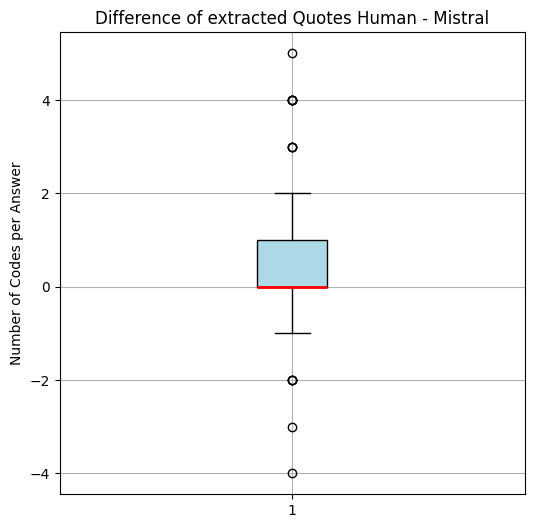

In [ ]:
# Calculate differences between human and LLM codings
data_answers['code_diff'] = data_answers['num_codes_human'] - data_answers['num_codes_llm']

# How often are the number of codes identical?
same_codes = (data_answers['code_diff'] == 0).sum()
total_answers = len(data_answers)

print(f"Same number of codes in {same_codes}/{total_answers} cases ({same_codes/total_answers:.2%}).")

# Average absolute difference in number of codes
mean_diff = data_answers['code_diff'].abs().mean()

print(f"Average Absolute Difference: {mean_diff:.2f} codes per answer.")

# Visualize code difference distribution
plt.figure(figsize=(6, 6))
box = plt.boxplot(data_answers['code_diff'].dropna(), vert=True, patch_artist=True)

# Set box color
for patch in box['boxes']:
    patch.set_facecolor('lightblue')

# Highlight median
for median in box['medians']:
    median.set(color='red', linewidth=2)

# Additional plot settings
plt.title('Difference of extracted Quotes Human - Mistral')
plt.ylabel('Number of Codes per Answer')
plt.grid(True)
plt.show()

# 3. Comparing Quotes Between Human and LLM


In this step, we compare the individual quotes extracted by human coders with those generated by the LLMs, with the goal of assessing how accurately the model can replicate human-selected content.

To quantify this alignment, we use two similarity metrics:

- **Surface similarity**: Measured using the ROUGE-1
- **Semantic similarity**: Measured via cosine similarity between sentence embeddings  

A quote pair is considered a **match** if either of the following thresholds is met:

- ROUGE-1 score ≥ 0.50  
- Cosine similarity ≥ 0.90

Based on these criteria, we compute standard evaluation metrics: **precision**, **recall**, and **F1-score**.

To better reflect different evaluation perspectives, we distinguish between two matching strategies:

####  Multiple Matching (`match_quote_multiple`)
Every human quote that meets the threshold with any LLM quote is counted as a match.  
This approach allows multiple human quotes to match the same LLM quote and reflects a **recall-oriented** evaluation.

#### Single Matching (`quote_match_single`)
In this stricter variant, only the **first** human quote that matches a given LLM quote is considered valid.  
All subsequent matches to the same LLM quote are ignored. This prevents overcounting and is better suited for a **precision-focused** analysis, where each LLM quote should ideally correspond to a unique human annotation.


In [ ]:
# Helper function to prepare input for the E5 model
def to_e5_input(task: str, texts: list[str]) -> list[str]:
    """
    Format sentences for the E5 embedding model using task-specific instruction format.

    Args:
        task (str): Instruction for the model (e.g., "semantic similarity").
        texts (list[str]): List of raw text inputs.

    Returns:
        list[str]: Formatted strings in the E5 input style.
    """
    return [f"Instruct: {task} Query: {text}" for text in texts]

def compare_human_vs_llm_by_question(data_human, data_llm):
    """
    Matches human and LLM quotes per question using semantic (cosine) and surface (ROUGE-1) similarity.

    A match is accepted if ROUGE ≥ 0.50, else if cosine ≥ 0.90.

    Args:
        data_human (pd.DataFrame): Human quotes with Person_ID, Question_ID, Quote_ID, quote
        data_llm (pd.DataFrame): LLM quotes in the same format

    Returns:
        Tuple:
            - Match results (pd.DataFrame)
            - Human embeddings (np.ndarray)
            - LLM embeddings (np.ndarray)
            - Human quotes (List[str])
            - LLM quotes (List[str])
    """

    # Define task for embeddings
    task = "Find the most semantically similar quotes from a transcribed interview answer in German."

    # Prepare and embed LLM quotes
    data_llm = data_llm.copy()
    data_llm["quote_str"] = data_llm["quote"].astype(str)
    data_llm["e5_input"] = to_e5_input(task, data_llm["quote_str"])
    data_llm["embedding"] = model.encode(
        data_llm["e5_input"].tolist(), normalize_embeddings=True
    ).tolist()

    results = []
    human_embeddings = []
    human_quotes = []

    for _, row in data_human.iterrows():
        person_id = row["Person_ID"]
        question_id = row["Question_ID"]
        quote_id = row["Quote_ID"]
        human_quote = str(row["quote"])

        # Filter LLM quotes for the same person and question
        subset = data_llm[
            (data_llm["Person_ID"] == person_id) &
            (data_llm["Question_ID"] == question_id)
        ].reset_index(drop=True)

        if subset.empty:
            # No LLM quotes available for this person/question
            results.append({
                "Person_ID": person_id,
                "Question_ID": question_id,
                "Human_Quote_ID": quote_id,
                "Human_Quote": human_quote,
                "Best_LLM_Quote_ID": "NO_MATCH",
                "Best_LLM_Quote": "NO_MATCH",
                "Cosine_Quote": False,
                "Cosine_Score": False,
                "ROUGE_Quote": False,
                "ROUGE_Score": False,
                "Same_Match_ID": False,
            })
            continue

        # Extract embeddings and IDs from LLM subset
        llm_embeddings = np.vstack(subset["embedding"].values)
        llm_quotes = subset["quote_str"].tolist()
        llm_quote_ids = subset["Quote_ID"].tolist()

        # Encode the human quote
        emb_human = model.encode(
            [f"Instruct: {task}\nQuery: {human_quote}"], normalize_embeddings=True
        )
        human_embeddings.append(emb_human[0])
        human_quotes.append(human_quote)

        # Compute cosine similarity
        cosine_sim = cosine_similarity(emb_human, llm_embeddings)[0]
        best_cos_idx = cosine_sim.argmax()
        best_cos_score = cosine_sim[best_cos_idx]

        # Compute ROUGE-1 F1 scores
        rouge_scores = [scorer.score(human_quote, q)["rouge1"].fmeasure for q in llm_quotes]
        best_rouge_idx = pd.Series(rouge_scores).idxmax()
        best_rouge_score = rouge_scores[best_rouge_idx]

        # Determine final match
        if best_rouge_score >= 0.5:
            matched_idx = best_rouge_idx
            matched_id = llm_quote_ids[matched_idx]
        elif best_cos_score >= 0.9:
            matched_idx = best_cos_idx
            matched_id = llm_quote_ids[matched_idx]
        else:
            matched_idx = None
            matched_id = "NO_MATCH"

        results.append({
            "Person_ID": person_id,
            "Question_ID": question_id,
            "Human_Quote_ID": quote_id,
            "Human_Quote": human_quote,
            "Best_LLM_Quote_ID": matched_id,
            "Best_LLM_Quote": llm_quotes[best_cos_idx],
            "Cosine_Quote": llm_quotes[best_cos_idx],
            "Cosine_Score": round(best_cos_score, 4),
            "ROUGE_Quote": llm_quotes[best_rouge_idx],
            "ROUGE_Score": round(best_rouge_score, 4),
            "Same_Match_ID": best_cos_idx == best_rouge_idx,
        })

    return (
        pd.DataFrame(results),
        np.vstack(human_embeddings),
        np.vstack(data_llm["embedding"].values),
        human_quotes,
        data_llm["quote_str"].tolist()
    )

In [ ]:
# Run the matching
df_mappings, emb_human, emb_llm, quotes_human, quotes_llm = compare_human_vs_llm_by_question(data_human, data_llm)

In [ ]:
# Identify quote-level matches using threshold-based criteria
df_mappings["match_quote_multiple"] = (
    (df_mappings["Cosine_Score"] >= 0.9) | (df_mappings["ROUGE_Score"] >= 0.5)
).fillna(False)

# Initialize single-match column with False
df_mappings["quote_match_single"] = False

# Filter for valid matches based on thresholds
valid_matches = df_mappings[df_mappings["match_quote_multiple"]]

# Ensure each LLM quote is only counted once by marking the first human match only
for llm_quote_id, group in valid_matches.groupby("Best_LLM_Quote_ID"):
    first_match_index = group.index[0]
    df_mappings.loc[first_match_index, "quote_match_single"] = True

# Display match distributions
print("Quote-level matches (multiple allowed):")
print(df_mappings["match_quote_multiple"].value_counts())

print("\nQuote-level matches (first only):")
print(df_mappings["quote_match_single"].value_counts())


Quote-level matches (multiple allowed):
match_quote_multiple
True     346
False     45
Name: count, dtype: int64

Quote-level matches (first only):
quote_match_single
True     267
False    124
Name: count, dtype: int64


In [ ]:
df_mappings.head(1)

,Person_ID,Question_ID,Human_Quote_ID,Human_Quote,Best_LLM_Quote_ID,Best_LLM_Quote,Cosine_Quote,Cosine_Score,ROUGE_Quote,ROUGE_Score,Same_Match_ID,match_quote_multiple,quote_match_single
0,1,1,Q002,"Das ganze Team war dort, wo wir zusammen unser...",Q001,Wenn ich über das letzte Jahr nachdenke und am...,Wenn ich über das letzte Jahr nachdenke und am...,0.9488,Wenn ich über das letzte Jahr nachdenke und am...,0.7097,True,True,True


We treat human-extracted quotes as the ground truth.  
Each quote predicted by the LLM is classified as one of the following:

| Outcome              | Description                                                       |
|----------------------|-------------------------------------------------------------------|
| True Positive (TP)  | The LLM correctly reproduces a quote found in the human annotation |
| False Positive (FP) | The LLM generates a quote not present in the human annotations      |
| False Negative (FN) | The LLM fails to identify a quote that was extracted by a human     |

Based on these outcomes, we compute the following evaluation metrics:


  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$


  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$


  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$


In [ ]:
# --- Evaluation with multiple LLM quote matches allowed ---

# Count True Positives (TP): all human quotes that matched any LLM quote
true_positives = df_mappings[df_mappings["match_quote_multiple"]].shape[0]

# False Positives (FP): unmatched LLM quotes used as best match
false_positives = data_llm["Quote_ID"].nunique() - df_mappings["Best_LLM_Quote_ID"].nunique()

# False Negatives (FN): human quotes that were not matched
false_negatives = df_mappings[df_mappings["match_quote_multiple"] != True].shape[0]

# Display raw counts
print(f"True Positives (TP): {true_positives}")
print(f"False Positives (FP): {false_positives}")
print(f"False Negatives (FN): {false_negatives}")

# Compute evaluation metrics
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Display results
print(f"\nEvaluation Metrics (Multiple Matching):")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1_score:.4f}")


True Positives (TP): 346
False Positives (FP): 86
False Negatives (FN): 45

Evaluation Metrics (Multiple Matching):
Precision:  0.8009
Recall:     0.8849
F1-Score:   0.8408


In [ ]:
# --- Evaluation with single LLM quote matches allowed ---

# Count True Positives (TP): valid one-to-one matches
true_positives = df_mappings[df_mappings["quote_match_single"]].shape[0]

# False Positives (FP): unmatched LLM quotes used as best match
false_positives = data_llm["Quote_ID"].nunique() - df_mappings["Best_LLM_Quote_ID"].nunique()

# False Negatives (FN): human quotes that were not matched
false_negatives = df_mappings[df_mappings["quote_match_single"] != True].shape[0]

# Display raw counts
print(f"True Positives (TP): {true_positives}")
print(f"False Positives (FP): {false_positives}")
print(f"False Negatives (FN): {false_negatives}")

# Compute evaluation metrics
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Display results
print(f"\nEvaluation Metrics (Single Matching):")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1_score:.4f}")


True Positives (TP): 267
False Positives (FP): 86
False Negatives (FN): 124

Evaluation Metrics (Single Matching):
Precision:  0.7564
Recall:     0.6829
F1-Score:   0.7177


In [ ]:
# --- statistical comparing the duplicates ---

# Count the number of unique human quotes
human_quote_counts = df_mappings["Human_Quote_ID"].nunique()

# Count the number of unique LLM quotes used as "Best Match"
llm_quote_counts = df_mappings["Best_LLM_Quote_ID"].nunique()

# Step 1: Identify LLM quotes that were matched to more than one human quote
used_llm_ids = df_mappings.loc[df_mappings["Best_LLM_Quote_ID"] != "NO_MATCH", "Best_LLM_Quote_ID"]

# Count how often each LLM quote was used
reuse_counts = used_llm_ids.value_counts()

# Filter for LLM quote IDs that were used more than once
dupes = reuse_counts[reuse_counts > 1]

print("LLM quotes used more than once (ID -> frequency):")
print(dupes)

# Additional statistics (optional)
print(f"\nNumber of distinct reused LLM quotes: {dupes.size}")
print(f"Total reuse beyond first use: {dupes.sum() - dupes.size}")

# Step 2: Filter all rows where the LLM quote was reused
reused_rows = df_mappings[df_mappings["Best_LLM_Quote_ID"].isin(dupes.index)].copy()

# Step 3: Calculate length (in words) of human and LLM quotes
reused_rows.loc[:, "Human_Quote_Length"] = reused_rows["Human_Quote"].str.split().str.len()
reused_rows.loc[:, "Best_LLM_Quote_Length"] = reused_rows["Best_LLM_Quote"].str.split().str.len()

# Optional: Compare average quote lengths
print("\n📏 Average quote length (in words):")
print("Human Quotes:", reused_rows["Human_Quote_Length"].mean())
print("LLM Quotes:", reused_rows["Best_LLM_Quote_Length"].mean())


LLM quotes used more than once (ID -> frequency):
Best_LLM_Quote_ID
Q328    4
Q213    4
Q267    4
Q232    4
Q253    3
       ..
Q025    2
Q054    2
Q051    2
Q011    2
Q003    2
Name: count, Length: 61, dtype: int64

Number of distinct reused LLM quotes: 61
Total reuse beyond first use: 79

📏 Average quote length (in words):
Human Quotes: 36.56428571428572
LLM Quotes: 73.65714285714286


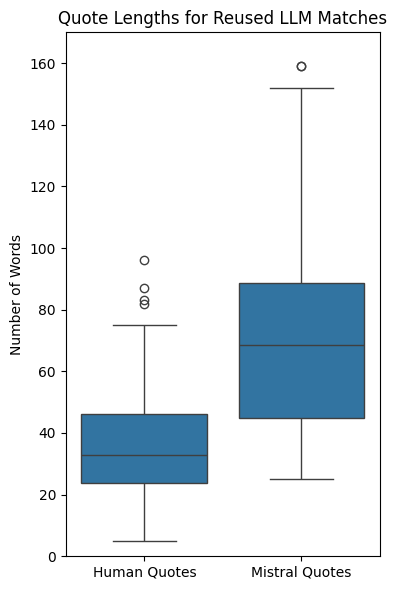

In [ ]:
# --- visualization for comparing number of words for reused LLM quotes ---

# Prepare quote length data for plotting
plot_data = reused_rows[["Human_Quote_Length", "Best_LLM_Quote_Length"]].melt(
    var_name="Quote_Type", value_name="Length"
)

# Rename columns for cleaner axis labels
plot_data["Quote_Type"] = plot_data["Quote_Type"].replace({
    "Human_Quote_Length": "Human Quotes",
    "Best_LLM_Quote_Length": "Mistral Quotes"
})

# Create boxplot comparing quote lengths
plt.figure(figsize=(4, 6))
sns.boxplot(data=plot_data, x="Quote_Type", y="Length")
plt.ylabel("Number of Words")
plt.xlabel("")
plt.ylim(0, 170)
plt.title("Quote Lengths for Reused LLM Matches")
plt.tight_layout()
plt.show()


In [ ]:
df_mappings_export = df_mappings[["Person_ID", "Question_ID", "Human_Quote_ID", "Best_LLM_Quote_ID", "Cosine_Score", "ROUGE_Score", "match_quote_multiple", "quote_match_single"]]
df_mappings_export = df_mappings_export.rename(columns={
    "Cosine_Score": "Max_Cosine_Score",
    "ROUGE_Score": "Max_ROUGE_Score"
})
df_mappings_export

,Person_ID,Question_ID,Human_Quote_ID,Best_LLM_Quote_ID,Max_Cosine_Score,Max_ROUGE_Score,match_quote_multiple,quote_match_single
0,1,1,Q002,Q001,0.9488,0.7097,True,True
1,1,1,Q003,Q002,1.0000,1.0000,True,True
2,1,1,Q004,Q003,1.0000,1.0000,True,True
3,1,1,Q005,Q003,0.9008,0.3357,True,False
4,1,1,Q006,Q004,0.9994,0.9946,True,True
...,...,...,...,...,...,...,...,...
386,18,8,Q435,Q300,0.9895,0.9340,True,True
387,18,9,Q436,Q330,1.0000,1.0000,True,True
388,18,9,Q437,Q331,0.9769,0.9130,True,True
389,18,9,Q439,Q332,0.9424,0.6154,True,True


In [ ]:
df_mappings_export.to_csv("Qute-Comparsion-Mistral.csv", index = False)

# 4. Comparing Codes Between Human and LLM

In this step, we evaluate the alignment between thematic codes produced by human analysts and those generated by the LLM (Mistral).
We compare each human code (including its description) with all LLM codes by computing cosine similarity between multilingual sentence embeddings.

The comparison is based on the following procedure:

- Both human and LLM codes are embedded using task-specific prompts and the same embedding model (intfloat/multilingual-e5-large-instruct)

- Cosine similarity is computed between all human–LLM code pairs

- For each human code, the most similar LLM code is selected as a "best match"

- Matches with a similarity score ≥ 0.90 are treated as semantically aligned

The evaluation includes:

- A similarity heatmap

- Precision, recall, and F1-score (for both multiple and single allocation settings)



In [ ]:
# -- Prepare prompts for semantic code comparison --
prompt_human = "Codes and their descriptions from thematic analysis in German for comparison with English "
prompt_llm = "Codes and their descriptions from thematic analysis in English for comparison with German "

# Combine code and description into input format
codes_human["code_text_human"] = codes_human.apply(
    lambda x: f"Instruct: {prompt_human}\nQuery: {x['code']}:{x['code_description']}",
    axis=1
)
codes_llm["code_text_llm"] = codes_llm.apply(
    lambda x: f"Instruct: {prompt_llm}\nQuery: {x['code']}: {x['code_description']}",
    axis=1
)

# -- Generate embeddings using multilingual E5 model --
codes_emb_human = model.encode(codes_human["code_text_human"].tolist(), normalize_embeddings=True)
codes_emb_llm = model.encode(codes_llm["code_text_llm"].tolist(), normalize_embeddings=True)

# -- Compute cosine similarity matrix --
sim_matrix = util.dot_score(codes_emb_human, codes_emb_llm).cpu().numpy()
df_sim_code = pd.DataFrame(sim_matrix, index=codes_human["code"], columns=codes_llm["code"])

# -- Extract best match for each human code --
df_best_c = df_sim_code.idxmax(axis=1).to_frame(name="best_code_llm")
df_best_c["similarity_score"] = df_sim_code.max(axis=1).round(3)
df_best_c["code_human"] = df_best_c.index

# -- Add code descriptions to results --
df_best_code = df_best_c.reset_index(drop=True).sort_values("similarity_score", ascending=False)
df_best_code = df_best_c.merge(
    codes_human.rename(columns={"code": "code_human", "code_description": "description_human"}),
    on="code_human",
    how="left"
)
df_best_code = df_best_code.merge(
    codes_llm.rename(columns={"code": "best_code_llm", "code_description": "description_llm"}),
    on="best_code_llm",
    how="left"
)

In [ ]:
df_best_code.head()

,best_code_llm,similarity_score,code_human,description_human,code_text_human,description_llm,code_text_llm
0,Finding Joy at Work,0.959,Freude an der Arbeit,"Hierzu zählt auch ""passioniert sein"". Freude a...",Instruct: Codes and their descriptions from th...,"Experiencing joy and passion for one’s tasks, ...",Instruct: Codes and their descriptions from th...
1,Demonstrating Self-Confidence,0.968,Selbstvertrauen,"An sich selbst Glauben. Wissen, dass man Herau...",Instruct: Codes and their descriptions from th...,The belief in one’s ability to perform tasks a...,Instruct: Codes and their descriptions from th...
2,Feeling Trusted by Others,0.936,Vertrauen,"Vertrauen bezieht sich einerseits darauf, dass...",Instruct: Codes and their descriptions from th...,Experiencing trust from colleagues or superior...,Instruct: Codes and their descriptions from th...
3,Communicating Effectively,0.960,Kommunikationsfähigkeiten,"Dies beinhaltet etwa: Gut zuhören, klar kommun...",Instruct: Codes and their descriptions from th...,"Ability to listen attentively, communicate cle...",Instruct: Codes and their descriptions from th...
4,Making Confident Decisions,0.945,Wichtige Entscheidungen gut treffen können,"Entscheidungen treffen können, auch schwierige",Instruct: Codes and their descriptions from th...,"Capacity to make well-founded decisions, inclu...",Instruct: Codes and their descriptions from th...


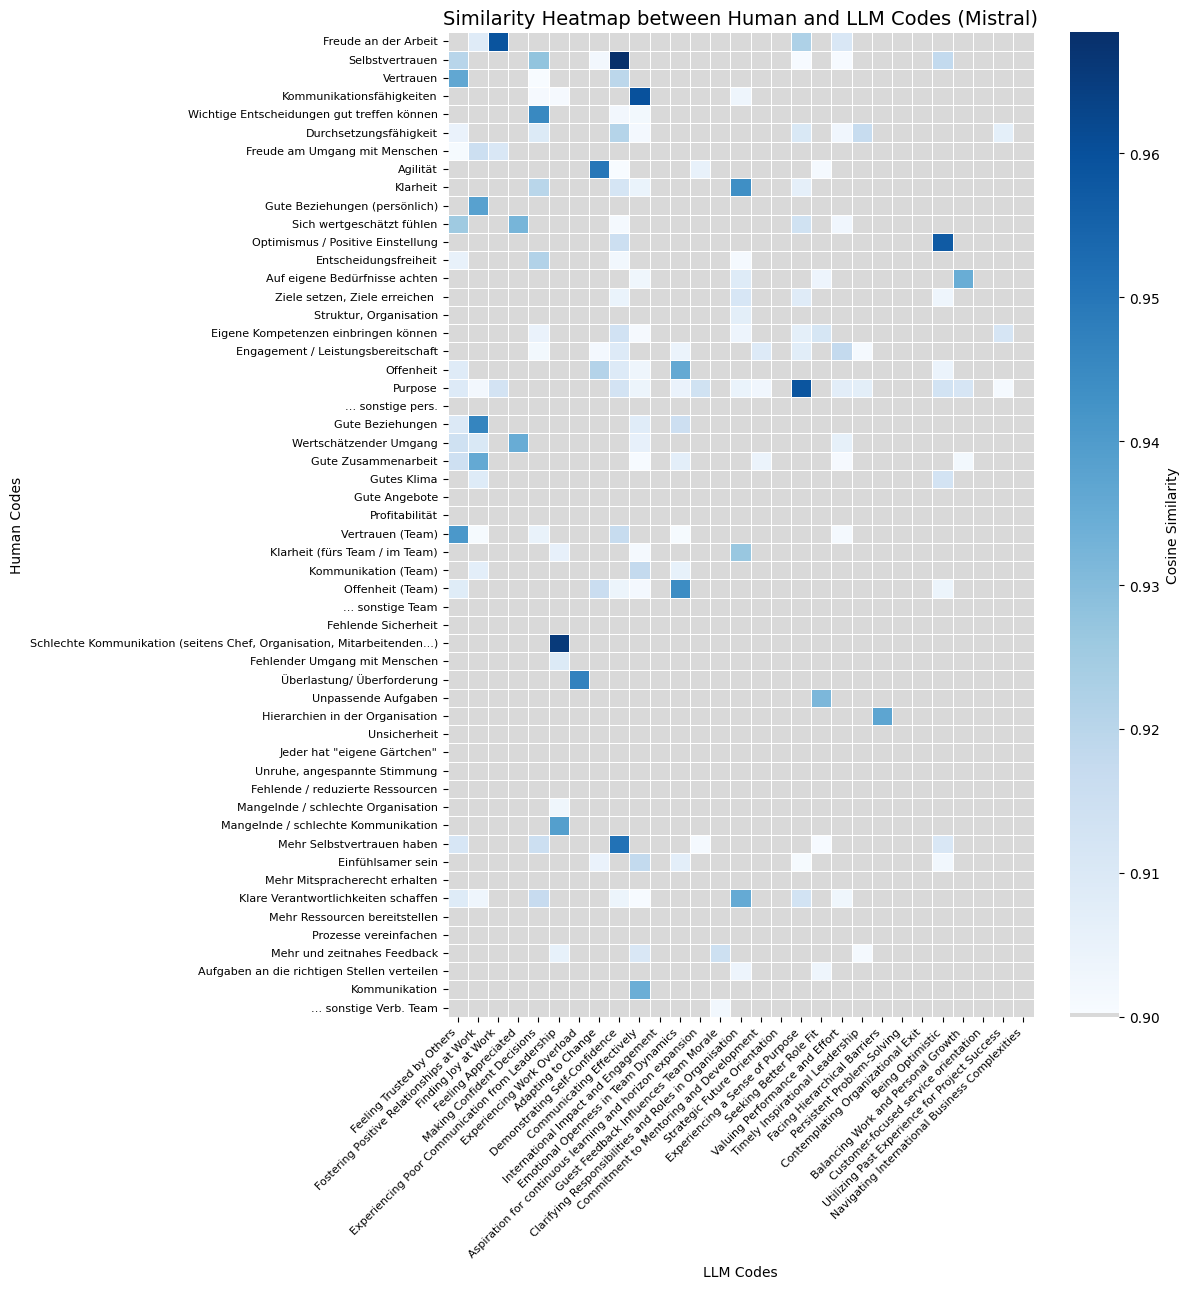

In [ ]:
# -- Define threshold --
threshold = 0.9

# -- Prepare data --
data = df_sim_code.copy()
masked = data < threshold

# -- Create custom colormap: gray for low values, blue for high --
n_colors = 256
blues = sns.color_palette("Blues", n_colors)
gray = [(0.85, 0.85, 0.85)]  # light gray in RGB
custom_cmap = ListedColormap(gray + blues)

# -- Normalize values: values below threshold mapped to gray --
adjusted = data.copy()
adjusted[masked] = threshold  # ensure gray gets the lowest colormap index

# -- Plot heatmap --
plt.figure(figsize=(12, 13))
sns.heatmap(
    adjusted,
    cmap=custom_cmap,
    linewidths=0.5,
    cbar_kws={'label': 'Cosine Similarity'},
    annot=False
)

# -- Format layout and axes --
plt.title("Similarity Heatmap between Human and LLM Codes (Mistral)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.xlabel("LLM Codes", fontsize=10)
plt.ylabel("Human Codes", fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# -- Append code frequency statistics --
# Frequency of human and LLM codes in the original datasets
human_code_counts = data_human["code"].value_counts().reset_index()
human_code_counts.columns = ["code_human", "code_human_count"]

llm_code_counts = data_llm["code"].value_counts().reset_index()
llm_code_counts.columns = ["best_code_llm", "code_llm_count"]

df_best_code = df_best_code.merge(human_code_counts, on="code_human", how="left")
df_best_code = df_best_code.merge(llm_code_counts, on="best_code_llm", how="left")

df_best_code.head()

,best_code_llm,similarity_score,code_human,description_human,code_text_human,description_llm,code_text_llm,code_human_count,code_llm_count
0,Finding Joy at Work,0.959,Freude an der Arbeit,"Hierzu zählt auch ""passioniert sein"". Freude a...",Instruct: Codes and their descriptions from th...,"Experiencing joy and passion for one’s tasks, ...",Instruct: Codes and their descriptions from th...,9,27
1,Demonstrating Self-Confidence,0.968,Selbstvertrauen,"An sich selbst Glauben. Wissen, dass man Herau...",Instruct: Codes and their descriptions from th...,The belief in one’s ability to perform tasks a...,Instruct: Codes and their descriptions from th...,7,20
2,Feeling Trusted by Others,0.936,Vertrauen,"Vertrauen bezieht sich einerseits darauf, dass...",Instruct: Codes and their descriptions from th...,Experiencing trust from colleagues or superior...,Instruct: Codes and their descriptions from th...,6,25
3,Communicating Effectively,0.960,Kommunikationsfähigkeiten,"Dies beinhaltet etwa: Gut zuhören, klar kommun...",Instruct: Codes and their descriptions from th...,"Ability to listen attentively, communicate cle...",Instruct: Codes and their descriptions from th...,19,31
4,Making Confident Decisions,0.945,Wichtige Entscheidungen gut treffen können,"Entscheidungen treffen können, auch schwierige",Instruct: Codes and their descriptions from th...,"Capacity to make well-founded decisions, inclu...",Instruct: Codes and their descriptions from th...,14,18


In [ ]:
# --- Evaluation: Multiple LLM allocations allowed ---

# Compute raw counts
true_positives_multi = df_best_code[df_best_code["similarity_score"] >= 0.9].shape[0]
false_positives_multi = len(set(data_llm["code"].unique()) - set(df_best_code["best_code_llm"].unique()))
false_negatives_multi = df_best_code[df_best_code["similarity_score"] < 0.9].shape[0]

# Display raw counts
print(f"True Positives (TP): {true_positives_multi}")
print(f"False Positives (FP): {false_positives_multi}")
print(f"False Negatives (FN): {false_negatives_multi}")

# Compute evaluation metrics
precision_multi = true_positives_multi / (true_positives_multi + false_positives_multi)
recall_multi = true_positives_multi / (true_positives_multi + false_negatives_multi)
f1_multi = 2 * (precision_multi * recall_multi) / (precision_multi + recall_multi)

# Display results
print(f"\nEvaluation Metrics (Multiple Matching):")
print(f"Precision:  {precision_multi:.4f}")
print(f"Recall:     {recall_multi:.4f}")
print(f"F1-Score:   {f1_multi:.4f}")


True Positives (TP): 44
False Positives (FP): 7
False Negatives (FN): 10

Evaluation Metrics (Multiple Matching):
Precision:  0.8627
Recall:     0.8148
F1-Score:   0.8381


In [ ]:
# --- Evaluation: Single LLM allocation allowed ---

# Compute raw counts
true_positives_single = df_best_code[df_best_code["similarity_score"] >= 0.9]["best_code_llm"].nunique()
false_positives_single = len(set(data_llm["code"].unique()) - set(df_best_code["best_code_llm"].unique()))
false_negatives_single = df_best_code["code_human"].nunique() - true_positives_single

# Display raw counts
print(f"\nTrue Positives (TP): {true_positives_single}")
print(f"False Positives (FP): {false_positives_single}")
print(f"False Negatives (FN): {false_negatives_single}")

# Compute evaluation metrics
precision_single = true_positives_single / (true_positives_single + false_positives_single)
recall_single = true_positives_single / (true_positives_single + false_negatives_single)
f1_single = 2 * (precision_single * recall_single) / (precision_single + recall_single)

# Display results
print(f"\nEvaluation Metrics (Single Matching):")
print(f"Precision:  {precision_single:.4f}")
print(f"Recall:     {recall_single:.4f}")
print(f"F1-Score:   {f1_single:.4f}")


True Positives (TP): 19
False Positives (FP): 7
False Negatives (FN): 35

Evaluation Metrics (Single Matching):
Precision:  0.7308
Recall:     0.3519
F1-Score:   0.4750


In [ ]:
# --- Prepare matching codes for later ---
THRESHOLD = 0.9

# Make a copy and mark all matches above the similarity threshold
code_matching = df_best_code.copy()
code_matching["multiple_match"] = code_matching["similarity_score"] >= THRESHOLD

# Get the index of the first match per LLM code above the threshold
first_hits = (
    code_matching.loc[code_matching["multiple_match"]]
    .sort_values(by="similarity_score", ascending=False)
    .drop_duplicates(subset="best_code_llm")
    .index
)

# Mark only the first eligible match as a single_match
code_matching["single_match"] = False
code_matching.loc[first_hits, "single_match"] = True

code_matching.head(1)


,best_code_llm,similarity_score,code_human,description_human,code_text_human,description_llm,code_text_llm,code_human_count,code_llm_count,multiple_match,single_match
0,Finding Joy at Work,0.959,Freude an der Arbeit,"Hierzu zählt auch ""passioniert sein"". Freude a...",Instruct: Codes and their descriptions from th...,"Experiencing joy and passion for one’s tasks, ...",Instruct: Codes and their descriptions from th...,9,27,True,True


In [ ]:
# --- multiple usages of codes ---
# Filter the dataframe to include only rows where similarity_score is >= 0.9
filtered_df = code_matching[code_matching["similarity_score"] >= 0.9]

# Count how often each best_code_llm appears in the filtered set
code_counts = filtered_df["best_code_llm"].value_counts()

# Optional: convert the result to a DataFrame for better formatting
code_counts_df = code_counts.reset_index()
code_counts_df.columns = ["best_code_llm", "count"]

# Display the result
code_counts_df

,best_code_llm,count
0,Clarifying Responsibilities and Roles in Organ...,6
1,Experiencing Poor Communication from Leadership,5
2,Demonstrating Self-Confidence,4
3,Fostering Positive Relationships at Work,4
4,Communicating Effectively,4
5,Guest Feedback Influences Team Morale,2
6,Feeling Trusted by Others,2
7,Being Optimistic,2
8,Feeling Appreciated,2
9,Emotional Openness in Team Dynamics,2


In [ ]:
df_code_export = code_matching[["code_human", "best_code_llm", "similarity_score", "description_human", "description_llm", "code_human_count", "code_llm_count", "multiple_match", "single_match"]]
df_code_export

,code_human,best_code_llm,similarity_score,description_human,description_llm,code_human_count,code_llm_count,multiple_match,single_match
0,Freude an der Arbeit,Finding Joy at Work,0.959,"Hierzu zählt auch ""passioniert sein"". Freude a...","Experiencing joy and passion for one’s tasks, ...",9,27,True,True
1,Selbstvertrauen,Demonstrating Self-Confidence,0.968,"An sich selbst Glauben. Wissen, dass man Herau...",The belief in one’s ability to perform tasks a...,7,20,True,True
2,Vertrauen,Feeling Trusted by Others,0.936,"Vertrauen bezieht sich einerseits darauf, dass...",Experiencing trust from colleagues or superior...,6,25,True,False
3,Kommunikationsfähigkeiten,Communicating Effectively,0.960,"Dies beinhaltet etwa: Gut zuhören, klar kommun...","Ability to listen attentively, communicate cle...",19,31,True,True
4,Wichtige Entscheidungen gut treffen können,Making Confident Decisions,0.945,"Entscheidungen treffen können, auch schwierige","Capacity to make well-founded decisions, inclu...",14,18,True,True
5,Durchsetzungsfähigkeit,Demonstrating Self-Confidence,0.921,Durch Überzeugungskraft andere Menschen motivi...,The belief in one’s ability to perform tasks a...,4,20,True,False
6,Freude am Umgang mit Menschen,Fostering Positive Relationships at Work,0.915,Freude am Umgang mit Menschen innerhalb und au...,"Having supportive, meaningful, and energizing ...",20,46,True,False
7,Agilität,Adapting to Change,0.950,Flexibel auf unvorhergesehene Ereignisse und n...,Willingness and ability to adapt to new or une...,13,35,True,True
8,Klarheit,Clarifying Responsibilities and Roles in Organ...,0.944,"Klarheit: Z. B. wissen, was die eigenen Aufgab...",Having a clear understanding of one’s responsi...,6,39,True,True
9,Gute Beziehungen (persönlich),Fostering Positive Relationships at Work,0.938,"Gute Beziehungen, die eine einzelne Person stä...","Having supportive, meaningful, and energizing ...",9,46,True,False


In [ ]:
df_code_export.to_csv("Code-Comparsion-Mistral.csv", index = False)

# 5. Comparing Themes Between Human and LLM

In this step, we compare thematic structures generated by humans and the LLM (Mistral) at the theme level.
The goal is to identify semantically equivalent themes by comparing multilingual sentence embeddings of each theme's name and description.

We apply the following procedure:

- Combine theme name and description using language-specific prompts

- Encode themes with the same embedding model used for code comparison

- Compute cosine similarity between all human and LLM themes

- Select the most similar LLM theme for each human theme

- Evaluate the alignment using a threshold-based classification (similarity ≥ 0.90)

In [ ]:
# -- Prepare prompts for semantic code comparison --
prompt_h = "Themes and their descriptions from thematic analysis in German for comparison with English "
prompt_l = "Themes and their descriptions from thematic analysis in English for comparison with German "

# Combine theme and description into input format
themes_human["theme_text_human"] = themes_human.apply(
    lambda x: f"Instruct: {prompt_h}\nQuery: {x['theme_name']}: {x['theme_description']}", axis=1
)
themes_llm["theme_text_llm"] = themes_llm.apply(
    lambda x: f"Instruct: {prompt_l}\nQuery: {x['theme_name']}: {x['theme_description']}", axis=1
)

# Generate embeddings
theme_emb_human = model.encode(themes_human["theme_text_human"].tolist(), normalize_embeddings=True)
theme_emb_llm = model.encode(themes_llm["theme_text_llm"].tolist(), normalize_embeddings=True)

# -- Compute cosine similarity matrix --
sim_matrix = util.dot_score(theme_emb_human, theme_emb_llm).cpu().numpy()
df_sim = pd.DataFrame(sim_matrix, index=themes_human["theme_name"], columns=themes_llm["theme_name"])

# -- Extract best match for each human theme --
df_best = df_sim.idxmax(axis=1).to_frame(name="best_theme_llm")
df_best["similarity_score"] = df_sim.max(axis=1).round(3)
df_best["theme_human"] = df_best.index

# -- Add theme descriptions to results --
df_best_theme = df_best.reset_index(drop=True)
df_best_theme = df_best_theme.merge(
    themes_human.rename(columns={"theme_name": "theme_human", "theme_description": "description_human"}),
    on="theme_human", how="left"
)
df_best_theme = df_best_theme.merge(
    themes_llm.rename(columns={"theme_name": "best_theme_llm", "theme_description": "description_llm"}),
    on="best_theme_llm", how="left"
)

In [ ]:
df_best_theme

,best_theme_llm,similarity_score,theme_human,description_human,theme_text_human,description_llm,theme_text_llm
0,Commitment to Mentoring and Development,0.882,Erfolgsfaktor persönlich,"Die Überkategorie ""Erfolgsfaktor persönlich"" b...",Instruct: Themes and their descriptions from t...,This theme emphasizes the commitment to mentor...,Instruct: Themes and their descriptions from t...
1,Enhancing Leadership and Team Dynamics,0.895,Erfolgsfaktor Team (/Organisation),"Die Überkategorie ""Erfolgsfaktor Team (/Organi...",Instruct: Themes and their descriptions from t...,This theme focuses on the strengths and develo...,Instruct: Themes and their descriptions from t...
2,Addressing Organizational Challenges and Impro...,0.861,Hemmer/Barrieren persönlich,"Diese Kategorie bezieht sich auf Aspekte, die ...",Instruct: Themes and their descriptions from t...,This theme addresses the weaknesses and areas ...,Instruct: Themes and their descriptions from t...
3,Addressing Organizational Challenges and Impro...,0.891,Hemmer/Barrieren Team (/Organisation),I. d. R. bezieht diese Kategorie sich auf Aspe...,Instruct: Themes and their descriptions from t...,This theme addresses the weaknesses and areas ...,Instruct: Themes and their descriptions from t...
4,Commitment to Mentoring and Development,0.893,Verbesserungspotenzial persönlich,Beschrieb Verbesserungspotenzial persönlich: A...,Instruct: Themes and their descriptions from t...,This theme emphasizes the commitment to mentor...,Instruct: Themes and their descriptions from t...
5,Addressing Organizational Challenges and Impro...,0.915,Verbesserungspotenzial Team/Organisation,Beschrieb Verbesserungspotenzial Team/Organisa...,Instruct: Themes and their descriptions from t...,This theme addresses the weaknesses and areas ...,Instruct: Themes and their descriptions from t...


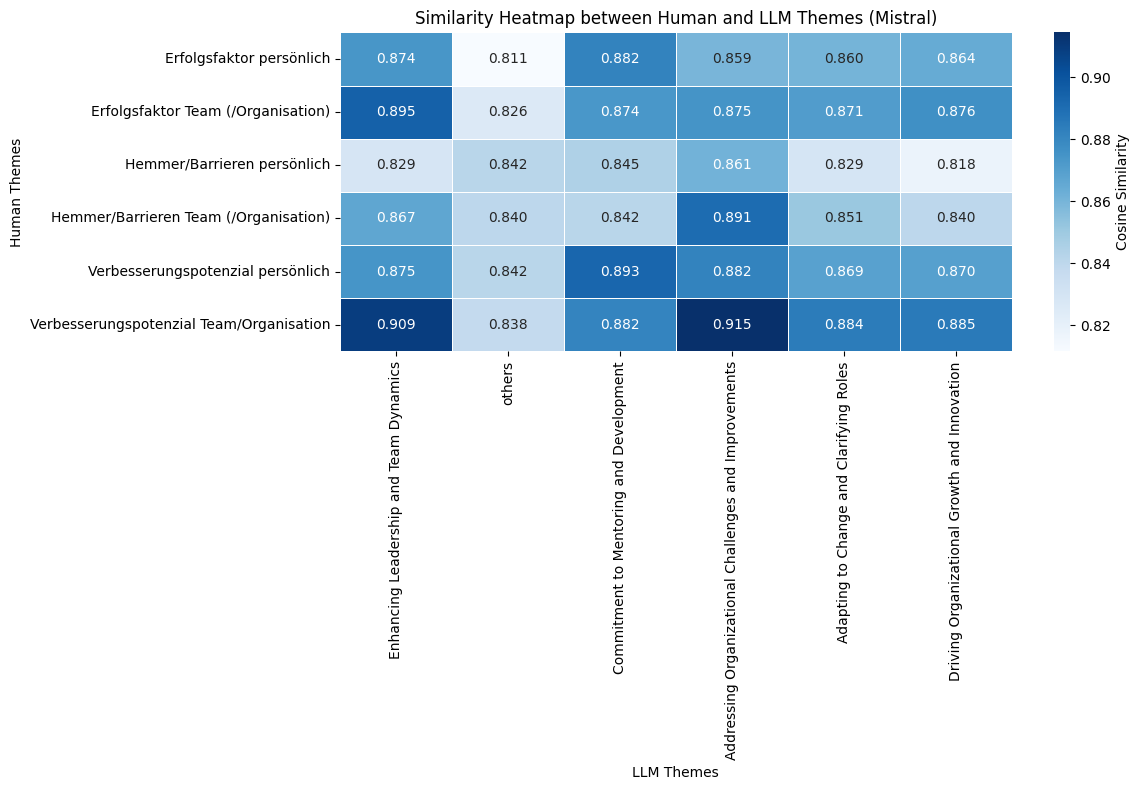

In [ ]:
# -- Plot similarity heatmap --
plt.figure(figsize=(12, 8))
sns.heatmap(df_sim, annot=True, fmt=".3f", cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Cosine Similarity'})
plt.title("Similarity Heatmap between Human and LLM Themes (Mistral)")
plt.xlabel("LLM Themes")
plt.ylabel("Human Themes")
plt.tight_layout()
plt.show()

In [ ]:
# Add theme frequency statistics
theme_counts_human = data_human["theme_name"].value_counts().reset_index()
theme_counts_human.columns = ["theme_human", "theme_human_count"]
df_best_theme = df_best_theme.merge(theme_counts_human, on="theme_human", how="left")

theme_counts_llm = data_llm["theme_name"].value_counts().reset_index()
theme_counts_llm.columns = ["best_theme_llm", "theme_llm_count"]
df_best_theme = df_best_theme.merge(theme_counts_llm, on="best_theme_llm", how="left")

df_best_theme

,best_theme_llm,similarity_score,theme_human,description_human,theme_text_human,description_llm,theme_text_llm,theme_human_count,theme_llm_count
0,Commitment to Mentoring and Development,0.882,Erfolgsfaktor persönlich,"Die Überkategorie ""Erfolgsfaktor persönlich"" b...",Instruct: Themes and their descriptions from t...,This theme emphasizes the commitment to mentor...,Instruct: Themes and their descriptions from t...,201,39
1,Enhancing Leadership and Team Dynamics,0.895,Erfolgsfaktor Team (/Organisation),"Die Überkategorie ""Erfolgsfaktor Team (/Organi...",Instruct: Themes and their descriptions from t...,This theme focuses on the strengths and develo...,Instruct: Themes and their descriptions from t...,97,147
2,Addressing Organizational Challenges and Impro...,0.861,Hemmer/Barrieren persönlich,"Diese Kategorie bezieht sich auf Aspekte, die ...",Instruct: Themes and their descriptions from t...,This theme addresses the weaknesses and areas ...,Instruct: Themes and their descriptions from t...,37,35
3,Addressing Organizational Challenges and Impro...,0.891,Hemmer/Barrieren Team (/Organisation),I. d. R. bezieht diese Kategorie sich auf Aspe...,Instruct: Themes and their descriptions from t...,This theme addresses the weaknesses and areas ...,Instruct: Themes and their descriptions from t...,18,35
4,Commitment to Mentoring and Development,0.893,Verbesserungspotenzial persönlich,Beschrieb Verbesserungspotenzial persönlich: A...,Instruct: Themes and their descriptions from t...,This theme emphasizes the commitment to mentor...,Instruct: Themes and their descriptions from t...,5,39
5,Addressing Organizational Challenges and Impro...,0.915,Verbesserungspotenzial Team/Organisation,Beschrieb Verbesserungspotenzial Team/Organisa...,Instruct: Themes and their descriptions from t...,This theme addresses the weaknesses and areas ...,Instruct: Themes and their descriptions from t...,33,35


In [ ]:
# --- Evaluation: Multiple LLM allocations allowed ---

# Compute raw counts
true_positives_multi = df_best_theme[df_best_theme["similarity_score"] >= 0.9].shape[0]
false_positives_multi = len(set(data_llm["theme_name"].unique()) - set(df_best_theme["best_theme_llm"].unique()))
false_negatives_multi = df_best_theme["theme_human"].nunique() - true_positives_multi

# Display raw counts
print(f"True Positives (TP): {true_positives_multi}")
print(f"False Positives (FP): {false_positives_multi}")
print(f"False Negatives (FN): {false_negatives_multi}")

# Compute metrics
precision_multi = true_positives_multi / (true_positives_multi + false_positives_multi)
recall_multi = true_positives_multi / (true_positives_multi + false_negatives_multi)
f1_multi = 2 * (precision_multi * recall_multi) / (precision_multi + recall_multi)

# Display results
print(f"\nEvaluation Metrics (Multiple Matching):")
print(f"Precision:  {precision_multi:.4f}")
print(f"Recall:     {recall_multi:.4f}")
print(f"F1-Score:   {f1_multi:.4f}")

True Positives (TP): 1
False Positives (FP): 3
False Negatives (FN): 5

Evaluation Metrics (Multiple Matching):
Precision:  0.2500
Recall:     0.1667
F1-Score:   0.2000


In [ ]:
# --- Evaluation: Single LLM allocation allowed ---

# Compute raw counts
true_positives_single = df_best_theme[df_best_theme["similarity_score"] >= 0.9]["best_theme_llm"].nunique()
false_positives_single = len(set(data_llm["theme_name"].unique()) - set(df_best_theme["best_theme_llm"].unique()))
false_negatives_single = df_best_theme["theme_human"].nunique() - true_positives_single

# Display raw counts
print(f"\nTrue Positives (TP): {true_positives_single}")
print(f"False Positives (FP): {false_positives_single}")
print(f"False Negatives (FN): {false_negatives_single}")

# Compute metrics
precision_single = true_positives_single / (true_positives_single + false_positives_single)
recall_single = true_positives_single / (true_positives_single + false_negatives_single)
f1_single = 2 * (precision_single * recall_single) / (precision_single + recall_single)

# Display results
print(f"\nEvaluation Metrics (Single Matching):")
print(f"Precision:  {precision_single:.4f}")
print(f"Recall:     {recall_single:.4f}")
print(f"F1-Score:   {f1_single:.4f}")


True Positives (TP): 1
False Positives (FP): 3
False Negatives (FN): 5

Evaluation Metrics (Single Matching):
Precision:  0.2500
Recall:     0.1667
F1-Score:   0.2000


In [ ]:
# --- Prepare matching themes for later ---
THRESHOLD = 0.9

# Make a copy and mark all matches above the similarity threshold
theme_matching = df_best_theme.copy()
theme_matching["multiple_match"] = theme_matching["similarity_score"] >= THRESHOLD

# Get the index of the first match per LLM theme above the threshold
first_hits = (
    theme_matching[theme_matching["multiple_match"]]
    .sort_values(by="similarity_score", ascending=False)
    .drop_duplicates(subset="best_theme_llm")
    .index
)

# Mark only the first eligible match as a single_match
theme_matching["single_match"] = False
theme_matching.loc[first_hits, "single_match"] = True

theme_matching.head(1)

,best_theme_llm,similarity_score,theme_human,description_human,theme_text_human,description_llm,theme_text_llm,theme_human_count,theme_llm_count,multiple_match,single_match
0,Commitment to Mentoring and Development,0.882,Erfolgsfaktor persönlich,"Die Überkategorie ""Erfolgsfaktor persönlich"" b...",Instruct: Themes and their descriptions from t...,This theme emphasizes the commitment to mentor...,Instruct: Themes and their descriptions from t...,201,39,False,False


In [ ]:
df_theme_export = theme_matching[["theme_human", "best_theme_llm", "similarity_score", "description_human", "description_llm", "theme_human_count", "theme_llm_count", "multiple_match", "single_match"]]
df_theme_export

,theme_human,best_theme_llm,similarity_score,description_human,description_llm,theme_human_count,theme_llm_count,multiple_match,single_match
0,Erfolgsfaktor persönlich,Commitment to Mentoring and Development,0.882,"Die Überkategorie ""Erfolgsfaktor persönlich"" b...",This theme emphasizes the commitment to mentor...,201,39,False,False
1,Erfolgsfaktor Team (/Organisation),Enhancing Leadership and Team Dynamics,0.895,"Die Überkategorie ""Erfolgsfaktor Team (/Organi...",This theme focuses on the strengths and develo...,97,147,False,False
2,Hemmer/Barrieren persönlich,Addressing Organizational Challenges and Impro...,0.861,"Diese Kategorie bezieht sich auf Aspekte, die ...",This theme addresses the weaknesses and areas ...,37,35,False,False
3,Hemmer/Barrieren Team (/Organisation),Addressing Organizational Challenges and Impro...,0.891,I. d. R. bezieht diese Kategorie sich auf Aspe...,This theme addresses the weaknesses and areas ...,18,35,False,False
4,Verbesserungspotenzial persönlich,Commitment to Mentoring and Development,0.893,Beschrieb Verbesserungspotenzial persönlich: A...,This theme emphasizes the commitment to mentor...,5,39,False,False
5,Verbesserungspotenzial Team/Organisation,Addressing Organizational Challenges and Impro...,0.915,Beschrieb Verbesserungspotenzial Team/Organisa...,This theme addresses the weaknesses and areas ...,33,35,True,True


In [ ]:
df_theme_export.to_csv("Theme-Comparsion-Mistral.csv", index = False)

# 6. Quote, Code and Theme Agreement

In this step, we bring together quote-, code-, and theme-level matches to assess end-to-end consistency between human and LLM annotations.
We assign code and theme matches from earlier steps to each individual quote and compute final evaluation metrics based on both:

- Multiple Matching: an LLM code or theme can match multiple human codes/themes

- Single Matching: each LLM code or theme may only match one human counterpart

We evaluate performance based on exact matches for codes and themes assigned to aligned quote pairs.

In [ ]:
# --- STEP 1: Prepare lookup tables for human and LLM code/theme labels ---
human_lookup = data_human.set_index("Quote_ID")[["code", "theme_name"]].rename(
    columns={"code": "code_human", "theme_name": "theme_human"}
)
llm_lookup = data_llm.set_index("Quote_ID")[["code", "theme_name"]].rename(
    columns={"code": "code_llm", "theme_name": "theme_llm"}
)

# --- STEP 2: Join code/theme information with matched quotes ---
df_quote_eval = df_mappings.join(human_lookup, on="Human_Quote_ID").join(llm_lookup, on="Best_LLM_Quote_ID")
df_quote_eval = df_quote_eval.fillna("NO_MATCH").drop(columns=[
    "Cosine_Quote", "Cosine_Score", "ROUGE_Quote", "ROUGE_Score", "Same_Match_ID"
])

# --- STEP 3: Match code and theme pairs using previous similarity results ---
def get_match_dict(df, key_from, key_to, match_col):
    return df.set_index([key_from, key_to])[match_col].to_dict()

# Load mappings from previous steps
code_match_dict_multi = get_match_dict(code_matching, "code_human", "best_code_llm", "multiple_match")
theme_match_dict_multi = get_match_dict(theme_matching, "theme_human", "best_theme_llm", "multiple_match")
code_match_dict_single = get_match_dict(code_matching, "code_human", "best_code_llm", "single_match")
theme_match_dict_single = get_match_dict(theme_matching, "theme_human", "best_theme_llm", "single_match")

# Functions to apply match checks
def check_match(row, match_dict, col1, col2):
    return match_dict.get((row[col1], row[col2]), False)

# Apply both match variants
df_quote_eval["Code_Match_Multi"] = df_quote_eval.apply(lambda r: check_match(r, code_match_dict_multi, "code_human", "code_llm"), axis=1)
df_quote_eval["Theme_Match_Multi"] = df_quote_eval.apply(lambda r: check_match(r, theme_match_dict_multi, "theme_human", "theme_llm"), axis=1)
df_quote_eval["Code_Match_Single"] = df_quote_eval.apply(lambda r: check_match(r, code_match_dict_single, "code_human", "code_llm"), axis=1)
df_quote_eval["Theme_Match_Single"] = df_quote_eval.apply(lambda r: check_match(r, theme_match_dict_single, "theme_human", "theme_llm"), axis=1)


In [ ]:
def evaluate_match(df, column, label):
    """Prints precision, recall, and F1-score for the given match column."""
    tp = df[df[column]].shape[0]
    fp = data_llm["Quote_ID"].nunique() - df["Best_LLM_Quote_ID"].nunique()
    fn = df["Human_Quote_ID"].nunique() - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nEvaluation Metrics – {label}")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1-Score:   {f1:.4f}")


In [ ]:
# Multiple Matching
evaluate_match(df_quote_eval, "Code_Match_Multi", "Code-Level (Multiple Matching)")
evaluate_match(df_quote_eval, "Theme_Match_Multi", "Theme-Level (Multiple Matching)")

# Single Matching
evaluate_match(df_quote_eval, "Code_Match_Single", "Code-Level (Single Matching)")
evaluate_match(df_quote_eval, "Theme_Match_Single", "Theme-Level (Single Matching)")



Evaluation Metrics – Code-Level (Multiple Matching)
True Positives (TP): 117
False Positives (FP): 86
False Negatives (FN): 274
Precision:  0.5764
Recall:     0.2992
F1-Score:   0.3939

Evaluation Metrics – Theme-Level (Multiple Matching)
True Positives (TP): 2
False Positives (FP): 86
False Negatives (FN): 389
Precision:  0.0227
Recall:     0.0051
F1-Score:   0.0084

Evaluation Metrics – Code-Level (Single Matching)
True Positives (TP): 68
False Positives (FP): 86
False Negatives (FN): 323
Precision:  0.4416
Recall:     0.1739
F1-Score:   0.2495

Evaluation Metrics – Theme-Level (Single Matching)
True Positives (TP): 2
False Positives (FP): 86
False Negatives (FN): 389
Precision:  0.0227
Recall:     0.0051
F1-Score:   0.0084


In [ ]:
df_agreement_export = df_quote_eval[["Person_ID", "Question_ID", "Human_Quote_ID", "Best_LLM_Quote_ID", "match_quote_multiple", "quote_match_single", "code_human", "theme_human", "code_llm", "theme_llm", "Code_Match_Multi", "Theme_Match_Multi", "Code_Match_Single", "Theme_Match_Single"]]
df_agreement_export

,Person_ID,Question_ID,Human_Quote_ID,Best_LLM_Quote_ID,match_quote_multiple,quote_match_single,code_human,theme_human,code_llm,theme_llm,Code_Match_Multi,Theme_Match_Multi,Code_Match_Single,Theme_Match_Single
0,1,1,Q002,Q001,True,True,Gutes Klima,Erfolgsfaktor Team (/Organisation),Feeling Trusted by Others,Enhancing Leadership and Team Dynamics,False,False,False,False
1,1,1,Q003,Q002,True,True,Gute Beziehungen,Erfolgsfaktor Team (/Organisation),Fostering Positive Relationships at Work,Enhancing Leadership and Team Dynamics,True,False,True,False
2,1,1,Q004,Q003,True,True,Freude am Umgang mit Menschen,Erfolgsfaktor persönlich,Finding Joy at Work,others,False,False,False,False
3,1,1,Q005,Q003,True,False,Gute Beziehungen,Erfolgsfaktor Team (/Organisation),Finding Joy at Work,others,False,False,False,False
4,1,1,Q006,Q004,True,True,Wertschätzender Umgang,Erfolgsfaktor Team (/Organisation),Feeling Appreciated,Commitment to Mentoring and Development,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,18,8,Q435,Q300,True,True,Kommunikationsfähigkeiten,Erfolgsfaktor persönlich,Communicating Effectively,Enhancing Leadership and Team Dynamics,True,False,True,False
387,18,9,Q436,Q330,True,True,Entscheidungsfreiheit,Erfolgsfaktor persönlich,Feeling Trusted by Others,Enhancing Leadership and Team Dynamics,False,False,False,False
388,18,9,Q437,Q331,True,True,Klarheit,Erfolgsfaktor persönlich,Clarifying Responsibilities and Roles in Organ...,Adapting to Change and Clarifying Roles,True,False,True,False
389,18,9,Q439,Q332,True,True,Freude am Umgang mit Menschen,Erfolgsfaktor persönlich,Experiencing a Sense of Purpose,Commitment to Mentoring and Development,False,False,False,False


In [ ]:
df_agreement_export.to_csv("Quote-Agreement-Mistral.csv", index = False)

# 7. Quote, Code and Theme Similarity

In this final step, we assess how semantically similar the human- and LLM-assigned codes and themes are for each individual quote.
Using multilingual embeddings, we calculate cosine similarity between the descriptions of the respective code/theme pairs and evaluate alignment at the quote level.

We classify a quote-level match as successful if:

- The quote itself was matched (quote-level alignment)

- The similarity between the code or theme descriptions exceeds a threshold (≥ 0.90)

This enables a more nuanced view of LLM performance beyond surface label overlap.

In [ ]:
# STEP 1: Combine quote-level matches with code and theme descriptions
human_lookup = data_human.set_index("Quote_ID")[["code", "code_description", "theme_name", "theme_description"]].rename(
    columns={
        "code": "code_human", "code_description": "code_description_human",
        "theme_name": "theme_human", "theme_description": "theme_description_human"
    }
)
llm_lookup = data_llm.set_index("Quote_ID")[["code", "code_description", "theme_name", "theme_description"]].rename(
    columns={
        "code": "code_llm", "code_description": "code_description_llm",
        "theme_name": "theme_llm", "theme_description": "theme_description_llm"
    }
)

df_quote_embedding = df_mappings.join(human_lookup, on="Human_Quote_ID").join(llm_lookup, on="Best_LLM_Quote_ID")
df_quote_embedding = df_quote_embedding.fillna("NO_MATCH")

# STEP 2: Prepare embedding inputs
def format_input(code, desc, prompt):
    return f"Instruct: {prompt}\nQuery: {code}: {desc}"

# Prompts
prompt_code_human = "Codes and their descriptions from thematic analysis in German for comparison with English "
prompt_code_llm = "Codes and their descriptions from thematic analysis in English for comparison with German "
prompt_theme_human = "Themes and their descriptions from thematic analysis in German for comparison with English "
prompt_theme_llm = "Themes and their descriptions from thematic analysis in English for comparison with German "

# Create inputs for embedding
inputs_code_h = df_quote_embedding.apply(lambda x: format_input(x["code_human"], x["code_description_human"], prompt_code_human), axis=1)
inputs_code_l = df_quote_embedding.apply(lambda x: format_input(x["code_llm"], x["code_description_llm"], prompt_code_llm), axis=1)
inputs_theme_h = df_quote_embedding.apply(lambda x: format_input(x["theme_human"], x["theme_description_human"], prompt_theme_human), axis=1)
inputs_theme_l = df_quote_embedding.apply(lambda x: format_input(x["theme_llm"], x["theme_description_llm"], prompt_theme_llm), axis=1)

# STEP 3: Generate embeddings and compute cosine similarity
emb_code_h = model.encode(inputs_code_h.tolist(), normalize_embeddings=True)
emb_code_l = model.encode(inputs_code_l.tolist(), normalize_embeddings=True)
emb_theme_h = model.encode(inputs_theme_h.tolist(), normalize_embeddings=True)
emb_theme_l = model.encode(inputs_theme_l.tolist(), normalize_embeddings=True)

# Cosine similarity = dot product for normalized vectors
df_quote_embedding["code_similarity"] = np.sum(emb_code_h * emb_code_l, axis=1).round(4)
df_quote_embedding["theme_similarity"] = np.sum(emb_theme_h * emb_theme_l, axis=1).round(4)


In [ ]:
threshold = 0.9

# Classify quote-level matches (multiple allocation allowed)
df_quote_embedding["code_match"] = (
    (df_quote_embedding["code_similarity"] >= threshold) &
    (df_quote_embedding["match_quote_multiple"])
)

df_quote_embedding["theme_match"] = (
    (df_quote_embedding["theme_similarity"] >= threshold) &
    (df_quote_embedding["match_quote_multiple"])
)

# Classify for single allocation variant
df_quote_embedding["code_match_single"] = (
    (df_quote_embedding["code_similarity"] >= threshold) &
    (df_quote_embedding["quote_match_single"])
)

df_quote_embedding["theme_match_single"] = (
    (df_quote_embedding["theme_similarity"] >= threshold) &
    (df_quote_embedding["quote_match_single"])
)


In [ ]:
def evaluate_similarity(df, column, label):
    tp = df[df[column]].shape[0]
    fp = data_llm["Quote_ID"].nunique() - df["Best_LLM_Quote_ID"].nunique()
    fn = df["Human_Quote_ID"].nunique() - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nEvaluation Metrics – {label}")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1-Score:   {f1:.4f}")


In [ ]:
# Multiple Matching
evaluate_similarity(df_quote_embedding, "code_match", "Code Similarity (Multiple)")
evaluate_similarity(df_quote_embedding, "theme_match", "Theme Similarity (Multiple)")

# Single Matching
evaluate_similarity(df_quote_embedding, "code_match_single", "Code Similarity (Single)")
evaluate_similarity(df_quote_embedding, "theme_match_single", "Theme Similarity (Single)")



Evaluation Metrics – Code Similarity (Multiple)
True Positives (TP): 173
False Positives (FP): 86
False Negatives (FN): 218
Precision:  0.6680
Recall:     0.4425
F1-Score:   0.5323

Evaluation Metrics – Theme Similarity (Multiple)
True Positives (TP): 13
False Positives (FP): 86
False Negatives (FN): 378
Precision:  0.1313
Recall:     0.0332
F1-Score:   0.0531

Evaluation Metrics – Code Similarity (Single)
True Positives (TP): 137
False Positives (FP): 86
False Negatives (FN): 254
Precision:  0.6143
Recall:     0.3504
F1-Score:   0.4463

Evaluation Metrics – Theme Similarity (Single)
True Positives (TP): 10
False Positives (FP): 86
False Negatives (FN): 381
Precision:  0.1042
Recall:     0.0256
F1-Score:   0.0411


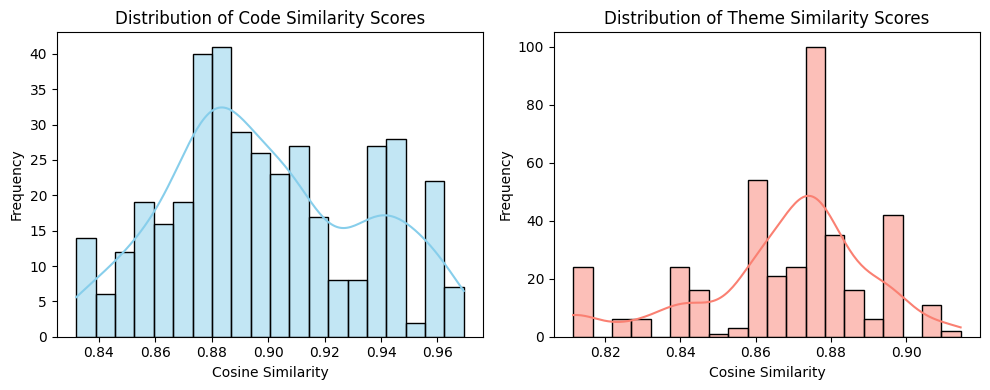

In [ ]:
# --- Visualization of Scores ---
plt.figure(figsize=(10, 4))

# Code similarity distribution
plt.subplot(1, 2, 1)
sns.histplot(df_quote_embedding["code_similarity"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Code Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")

# Theme similarity distribution
plt.subplot(1, 2, 2)
sns.histplot(df_quote_embedding["theme_similarity"], bins=20, kde=True, color="salmon")
plt.title("Distribution of Theme Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
df_similarity_export = df_quote_embedding[["Person_ID", "Question_ID", "Human_Quote_ID", "Best_LLM_Quote_ID", "match_quote_multiple", "quote_match_single", "code_human", "code_llm", "code_similarity", "theme_human","theme_llm", "theme_similarity"]]
df_similarity_export

,Person_ID,Question_ID,Human_Quote_ID,Best_LLM_Quote_ID,match_quote_multiple,quote_match_single,code_human,code_llm,code_similarity,theme_human,theme_llm,theme_similarity
0,1,1,Q002,Q001,True,True,Gutes Klima,Feeling Trusted by Others,0.8886,Erfolgsfaktor Team (/Organisation),Enhancing Leadership and Team Dynamics,0.8951
1,1,1,Q003,Q002,True,True,Gute Beziehungen,Fostering Positive Relationships at Work,0.9449,Erfolgsfaktor Team (/Organisation),Enhancing Leadership and Team Dynamics,0.8951
2,1,1,Q004,Q003,True,True,Freude am Umgang mit Menschen,Finding Joy at Work,0.9089,Erfolgsfaktor persönlich,others,0.8115
3,1,1,Q005,Q003,True,False,Gute Beziehungen,Finding Joy at Work,0.8816,Erfolgsfaktor Team (/Organisation),others,0.8257
4,1,1,Q006,Q004,True,True,Wertschätzender Umgang,Feeling Appreciated,0.9346,Erfolgsfaktor Team (/Organisation),Commitment to Mentoring and Development,0.8738
...,...,...,...,...,...,...,...,...,...,...,...,...
386,18,8,Q435,Q300,True,True,Kommunikationsfähigkeiten,Communicating Effectively,0.9596,Erfolgsfaktor persönlich,Enhancing Leadership and Team Dynamics,0.8742
387,18,9,Q436,Q330,True,True,Entscheidungsfreiheit,Feeling Trusted by Others,0.9048,Erfolgsfaktor persönlich,Enhancing Leadership and Team Dynamics,0.8742
388,18,9,Q437,Q331,True,True,Klarheit,Clarifying Responsibilities and Roles in Organ...,0.9432,Erfolgsfaktor persönlich,Adapting to Change and Clarifying Roles,0.8602
389,18,9,Q439,Q332,True,True,Freude am Umgang mit Menschen,Experiencing a Sense of Purpose,0.8955,Erfolgsfaktor persönlich,Commitment to Mentoring and Development,0.8817


In [ ]:
df_similarity_export.to_csv("Quote-Similarity-Mistral.csv", index = False)